<a href="https://colab.research.google.com/github/datascience-uniandes/classification_tutorial/blob/master/churn/churn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A/B Testing: Detección de cancelación de clientes

MINE-4101: Applied Data Science  
Univerisdad de los Andes  
  
Last update: Noviembre 2024

In [1]:
%pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install seaborn

In [3]:
from joblib import dump

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import ks_2samp
from sklearn.feature_selection import chi2

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, auc


In [4]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 100)

### Carga y entendimiento de datos

Vamos a cargar y caracterizar rápidamente los datos. Para ver este proceso en mayor detalle, puede revisar la práctica de clasificación original.

In [5]:
churn_df = pd.read_csv("./data/churn_train_val.csv")
test_df = pd.read_csv("./data/churn_test_labeled.csv")

In [6]:
churn_df.shape

(9000, 11)

In [7]:
test_df.shape

(1000, 11)

In [8]:
churn_df.dtypes

credit_score          int64
country              object
gender               object
age                   int64
tenure                int64
balance             float64
products_number       int64
credit_card           int64
active_member         int64
estimated_salary    float64
churn                 int64
dtype: object

In [9]:
churn_df.head()

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,781,Spain,Male,35,1,0.00,2,0,0,42117.90,0
1,701,Spain,Female,21,9,0.00,2,1,1,26327.42,0
2,685,Spain,Female,25,10,128509.63,1,1,0,121562.33,0
3,680,France,Male,34,3,143292.95,1,1,0,66526.01,0
4,756,Germany,Female,34,2,148200.72,1,0,0,194584.48,0


In [10]:
test_df.head()

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,713,Spain,Female,48,1,163760.82,1,0,0,157381.14,1
1,502,France,Male,30,4,0.00,2,1,1,66263.87,0
2,817,Germany,Male,45,9,101207.75,1,0,0,88211.12,1
3,730,France,Male,39,1,116537.60,1,0,0,145679.60,0
4,576,Spain,Male,52,2,100549.43,2,1,1,16644.16,0


### Entrenando con un primer modelo

Vamos a usar un Árbol de Decisión como nuestro primer clasificador usando sólo algunos de los atributos.

In [11]:
features = ["age", "balance", "country", "products_number", "active_member"]

Generaremos un pipeline, con el propósito de codificar en OneHot la única columna categórica ("Country").

In [12]:
pipeline_dt = Pipeline([
    ("transformer", ColumnTransformer([
        ("categorical", OneHotEncoder(), ["country"])
    ], remainder="passthrough")),
    ("classifier",  DecisionTreeClassifier())
]) 

Vamos a usar GridSearch para buscar los mejores valores de 3 hiperparámetros de los árboles de decisión.

In [13]:
param_grid_dt = {
    "classifier__max_depth": [3,4,5,6,7],
    "classifier__min_samples_leaf" : [5, 10, 15],
    "classifier__criterion": ["gini", "entropy", "log_loss"]
}

In [14]:
grid_dt = GridSearchCV(estimator=pipeline_dt, param_grid=param_grid_dt, scoring=["precision", "recall", "f1", "roc_auc"], refit="f1", cv=5, return_train_score=True)

In [15]:
grid_dt.fit(churn_df[features], churn_df["churn"])

d:\Desarrollo\Ciencia de Datos\A-b-testing-tutorial\.venv\Lib\site-packages\sklearn\compose\_column_transformer.py:1623: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('categorical',
                                                                         OneHotEncoder(),
                                                                         ['country'])])),
                                       ('classifier',
                                        DecisionTreeClassifier())]),
             param_grid={'classifier__criterion': ['gini', 'entropy',
                                                   'log_loss'],
                         'classifier__max_depth': [3, 4, 5, 6, 7],
                         'classifier__min_samples_leaf': [5, 10, 15]},
             refit='f1', return_train_score=True,
             scoring=['precision', 'recall', 'f1', 'roc_auc'])

Revisemos los mejores hiperparámetros:

In [16]:
grid_dt.best_params_

{'classifier__criterion': 'entropy',
 'classifier__max_depth': 7,
 'classifier__min_samples_leaf': 15}

Vamos a mostrar la matriz de confusión para los datos de entrenamiento y los datos de prueba.

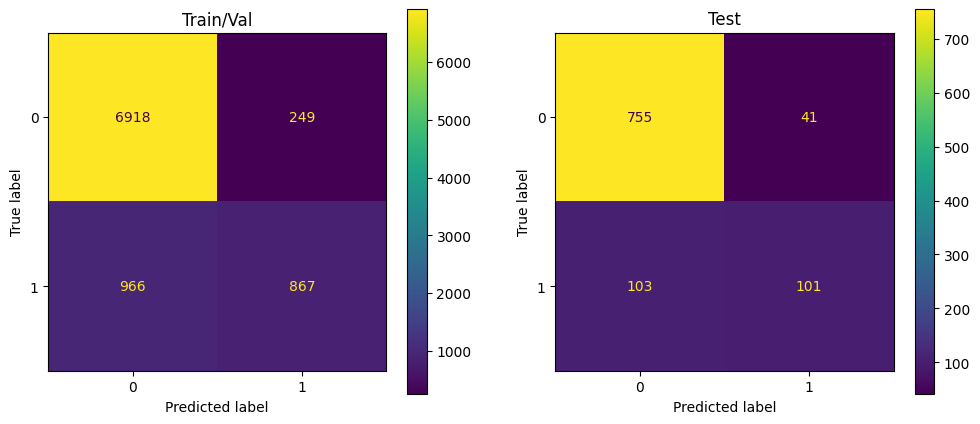

In [17]:
train_val_preds = grid_dt.best_estimator_.predict(churn_df[features])
test_preds = grid_dt.best_estimator_.predict(test_df[features])

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

train_val_cm = confusion_matrix(churn_df["churn"], train_val_preds, labels=grid_dt.best_estimator_.classes_)
train_val_disp = ConfusionMatrixDisplay(confusion_matrix=train_val_cm, display_labels=grid_dt.best_estimator_.classes_)
train_val_disp.plot(ax=axes[0])
axes[0].set_title("Train/Val")

test_cm = confusion_matrix(test_df["churn"], test_preds, labels=grid_dt.best_estimator_.classes_)
test_disp = ConfusionMatrixDisplay(confusion_matrix=test_cm, display_labels=grid_dt.best_estimator_.classes_)
test_disp.plot(ax=axes[1])
axes[1].set_title("Test")

plt.show()

Vemos que la precisión de la etiqueta objetivo (1= el cliente cancelará) es relativamente alta, sin embargo el recall está algo bajo. En resumen, los clientes que predecimos son en gran porcentaje los que van a cancelar, pero solo logramos detectar alrededor de la mitad de todos los clientes que van a abandonar según nuestro dataset.

In [18]:
print("Accuracy:")
print("- Train/Val:", accuracy_score(churn_df["churn"], train_val_preds))
print("- Test:", accuracy_score(test_df["churn"], test_preds))
print("Precision:")
print("- Train/Val:", precision_score(churn_df["churn"], train_val_preds))
print("- Test:", precision_score(test_df["churn"], test_preds))
print("\nRecall:")
print("- Train/Val:", recall_score(churn_df["churn"], train_val_preds))
print("- Test:", recall_score(test_df["churn"], test_preds))
print("\nF1:")
print("- Train/Val:", f1_score(churn_df["churn"], train_val_preds))
print("- Test:", f1_score(test_df["churn"], test_preds))
print("\nROC AUC:")
print("- Train/Val:", roc_auc_score(churn_df["churn"], train_val_preds))
print("- Test:", roc_auc_score(test_df["churn"], test_preds))

Accuracy:
- Train/Val: 0.865
- Test: 0.856
Precision:
- Train/Val: 0.7768817204301075
- Test: 0.7112676056338029

Recall:
- Train/Val: 0.47299509001636664
- Test: 0.4950980392156863

F1:
- Train/Val: 0.5879959308240081
- Test: 0.5838150289017341

ROC AUC:
- Train/Val: 0.7191262599516743
- Test: 0.721795250763622


## Entrenando con un segundo modelo

Vamos a intentar un nuevo modelo, esta vez un ensemble de árboles de decisión: Random Forest. Revisemos qué tal lo hace.

In [19]:
pipeline_rf = Pipeline([
    ("transformer", ColumnTransformer([
        ("categorical", OneHotEncoder(), ["country"])
    ], remainder="passthrough")),
    ("classifier",  RandomForestClassifier(random_state=10))
]) 

In [20]:
param_grid_rf = {
    "classifier__n_estimators": [50, 100, 150],
    "classifier__max_depth" : [3, 4, 5, 6],
    "classifier__class_weight": ["balanced", None]
}

In [21]:
grid_rf = GridSearchCV(estimator=pipeline_rf, param_grid=param_grid_rf, scoring=["precision", "recall", "f1", "roc_auc"], refit="f1", cv=5, return_train_score=True)


In [22]:
grid_rf.fit(churn_df[features], churn_df["churn"])


d:\Desarrollo\Ciencia de Datos\A-b-testing-tutorial\.venv\Lib\site-packages\sklearn\compose\_column_transformer.py:1623: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('categorical',
                                                                         OneHotEncoder(),
                                                                         ['country'])])),
                                       ('classifier',
                                        RandomForestClassifier(random_state=10))]),
             param_grid={'classifier__class_weight': ['balanced', None],
                         'classifier__max_depth': [3, 4, 5, 6],
                         'classifier__n_estimators': [50, 100, 150]},
             refit='f1', return_train_score=True,
             scoring=['precision', 'recall', 'f1', 'roc_auc'])

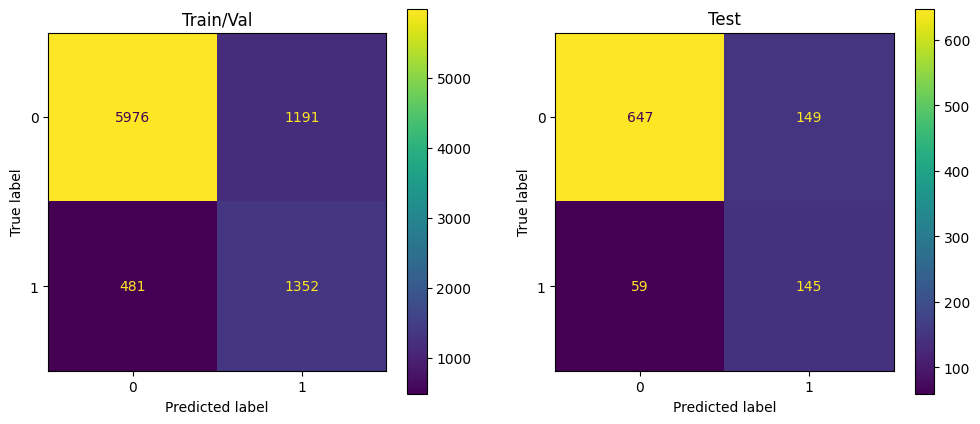

In [23]:
train_val_preds = grid_rf.best_estimator_.predict(churn_df[features])
test_preds = grid_rf.best_estimator_.predict(test_df[features])

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

train_val_cm = confusion_matrix(churn_df["churn"], train_val_preds, labels=grid_rf.best_estimator_.classes_)
train_val_disp = ConfusionMatrixDisplay(confusion_matrix=train_val_cm, display_labels=grid_rf.best_estimator_.classes_)
train_val_disp.plot(ax=axes[0])
axes[0].set_title("Train/Val")

test_cm = confusion_matrix(test_df["churn"], test_preds, labels=grid_rf.best_estimator_.classes_)
test_disp = ConfusionMatrixDisplay(confusion_matrix=test_cm, display_labels=grid_rf.best_estimator_.classes_)
test_disp.plot(ax=axes[1])
axes[1].set_title("Test")

plt.show()

En este caso podemos ver que la precisión se redujo considerablemente, pero nuestro recall aumentó considerablemente.

In [24]:
grid_rf.best_params_


{'classifier__class_weight': 'balanced',
 'classifier__max_depth': 6,
 'classifier__n_estimators': 100}

In [25]:
print("Accuracy:")
print("- Train/Val:", accuracy_score(churn_df["churn"], train_val_preds))
print("- Test:", accuracy_score(test_df["churn"], test_preds))
print("Precision:")
print("- Train/Val:", precision_score(churn_df["churn"], train_val_preds))
print("- Test:", precision_score(test_df["churn"], test_preds))
print("\nRecall:")
print("- Train/Val:", recall_score(churn_df["churn"], train_val_preds))
print("- Test:", recall_score(test_df["churn"], test_preds))
print("\nF1:")
print("- Train/Val:", f1_score(churn_df["churn"], train_val_preds))
print("- Test:", f1_score(test_df["churn"], test_preds))
print("\nROC AUC:")
print("- Train/Val:", roc_auc_score(churn_df["churn"], train_val_preds))
print("- Test:", roc_auc_score(test_df["churn"], test_preds))

Accuracy:
- Train/Val: 0.8142222222222222
- Test: 0.792
Precision:
- Train/Val: 0.5316555249705073
- Test: 0.4931972789115646

Recall:
- Train/Val: 0.7375886524822695
- Test: 0.7107843137254902

F1:
- Train/Val: 0.6179159049360147
- Test: 0.5823293172690763

ROC AUC:
- Train/Val: 0.7857051675973507
- Test: 0.7617991920386246


Ahora viene la pregunta. ¿Es mejor un modelo que el otro? Para esto vamos a usar A/B Testing.

## A/B Testing

Nuestro modelo de control será el árbol de decisión original. Nuestra variante será el modelo de Random Forest.

In [26]:
control = grid_dt.best_estimator_
variant = grid_rf.best_estimator_

Vamos a dividir el conjunto de datos de prueba en dos, y vamos a predecir los valores usando cada clasificador independientemente.

In [27]:
from sklearn.model_selection import train_test_split

xtestA, xtestB, ytestA, ytestB = train_test_split(test_df[features], test_df['churn'], test_size=0.5)

In [28]:
ypred_control=control.predict(xtestA)
ypred_variant=variant.predict(xtestB)


Vamos a validar usando Exactitud general: qué tan bien en general detecta cada clasificador los clientes que se van y los que se quedan. Debido a la naturaleza desbalanceada del problema, la exactitud inicial será bastante alta:

In [29]:
acc_control = (ypred_control==ytestA).astype(int)
acc_variante = (ypred_variant==ytestB).astype(int)

print(acc_control.mean())
print(acc_variante.mean())

0.84
0.814


In [30]:
from scipy import stats


t_stat, p_value = stats.ttest_rel(acc_control, acc_variante)
print(f"T-statistic: {t_stat}, P-value: {p_value}")

T-statistic: 1.0950154047070582, P-value: 0.27403813242215946


De acuerdo con esto, las distribuciones son suficientemente diferentes para indicar que si hay una diferencia significativa entre el control y la variante en términos de la Exactitud que, con alta confianza, no es producto del azar.

## Test de McNemar para la matriz de confusión

Vamos ahora a usar el [test de McNemar](https://en.wikipedia.org/wiki/McNemar%27s_test) para validar la diferencia entre ambos modelos a partir de una tabla de contingencia. Esta tabla es muy parecida a una matriz de confusión, sólo que compara los dos modelos entre sí, para determinar cuáles predicciones fueron correctas en ambos modelos, cuales incorrectas en ambas, y cuáles correctas sólo para uno de ellos. Para probar con múltiples clases es necesario probar con One vs All para cada clase (y probar si existe una diferencia significativa por clase para el clasificador), o usando el test de Cochran's Q también disponible en statsmodel.

In [31]:
%pip install statsmodels


Note: you may need to restart the kernel to use updated packages.


In [32]:
%pip install mlxtend

Note: you may need to restart the kernel to use updated packages.


In [33]:
from statsmodels.stats.contingency_tables import mcnemar
from sklearn.metrics import confusion_matrix
from mlxtend.evaluate import mcnemar_tables


In [34]:
ypred_control=control.predict(test_df[features])
ypred_variant=variant.predict(test_df[features]) 

Vamos a generar nuestra tabla de contingencia

In [35]:
tb = mcnemar_tables(test_df['churn'], 
                    ypred_control, 
                    ypred_variant)

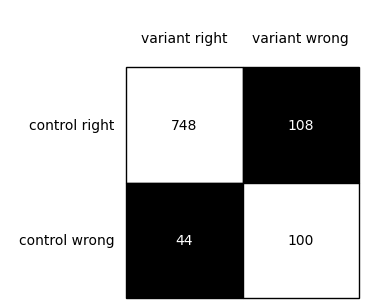

In [36]:
from mlxtend.plotting import checkerboard_plot
import matplotlib.pyplot as plt

brd = checkerboard_plot(tb['model_0 vs model_1'],
                        figsize=(3, 3),
                        fmt='%d',
                        col_labels=['variant right', 'variant wrong'],
                        row_labels=['control right', 'control wrong'])
plt.show()

Vemos acá entonces que ambos modelos predijeron correctamente las clases de 748 instancias, y ambos clasificaron incorrectamente 100 instancias. El control clasificó incorrectamente 44 instancias que la variante clasificó correctamente, mientras que la variante clasificó 108 instancias incorrectamente que el control clasificó correctamente. Hay un radio de 108:44, el control lo hizo mejor casi 2.5 veces que la variante.

In [37]:
conf_matrix = confusion_matrix(ypred_control, ypred_variant)

# Perform McNemar's test
result = mcnemar(tb['model_0 vs model_1'], exact=False)
print("McNemar’s Test Results:")
print(f"Statistic: {result.statistic}")
print(f"P-value: {result.pvalue}")

McNemar’s Test Results:
Statistic: 26.111842105263158
P-value: 3.2220184411707507e-07


Al hacer el test de McNemar, nos damos cuenta que la probabilidad de que ambos modelos lo hagan igual es bastante baja (mucho menor al 5%). Luego podemos determinar que la variante es efectivamente peor que el control.

## Test para las diferentes métricas

Vamos a usar ahora el t-test 5x2cv para comparar el rendimiento de los dos modelos usando diferentes métricas. Este modelo divide los datos en 50/50 5 veces, calculando dos métricas y a partir de esto, realizando el cálculo de la estadística t.

In [38]:
from mlxtend.evaluate import paired_ttest_5x2cv


t, p = paired_ttest_5x2cv(estimator1=control, estimator2=variant, X=test_df[features], y=test_df['churn'], scoring='accuracy', random_seed=1)
# summarize
print('P-value: %.3f, t-Statistic: %.3f' % (p, t))

P-value: 0.549, t-Statistic: 0.641


In [39]:
t, p = paired_ttest_5x2cv(estimator1=control, estimator2=variant, X=test_df[features], y=test_df['churn'], scoring='precision', random_seed=1)
# summarize
print('P-value: %.3f, t-Statistic: %.3f' % (p, t))

P-value: 0.228, t-Statistic: 1.374


In [40]:
t, p = paired_ttest_5x2cv(estimator1=control, estimator2=variant, X=test_df[features], y=test_df['churn'], scoring='recall', random_seed=1)
# summarize
print('P-value: %.3f, t-Statistic: %.3f' % (p, t))

P-value: 0.002, t-Statistic: -6.157


Como conclusión vemos que en términos de exactitud y precisión, ambos modelos no tienen diferencias significativas. Sin embargo, este test nos muestra que en términos de recall son suficientemente diferentes.

### ACTIVIDADES SUGERIDAS

1. Determine si los modelos son justos con relación al atributo "gender".
2. Utilice una estrategia de aumentación de datos para entrenar los modelos originales. Valide los modelos con las nuevas métricas.
3. Plantee un tercer modelo usando una *regresión logística*. Utilice pruebas A/B para determinar si su modelo es mejor o peor que el control.

